In [1]:
import os
import json
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys

sys.path.append('/Users/yutaro/MyDocument/02.Learn/16_blog_qiita/00_common/git_blog/src')
from lib.image import Video, pipeline_calc_white_lines, plt_imshow, visualize
from lib.image import canny, gaussian_blur, grayscale, region_of_interest, calc_region, hough_lines, weighted_img, pipeline_calc_white_lines


# [OpenCV]画像処理で道路の白線を検出する
- (option)色選択
  - 色選択すると、値が2値化されるためエッジ検出が強調され、エッジのノイズが増えてしまう。
- グレー画像
- エッジ検出
- 領域切り抜き
- ハフ直線検出

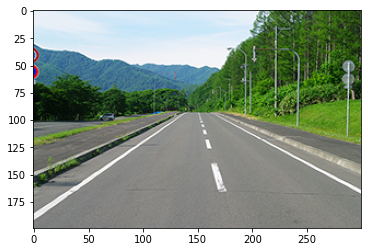

In [2]:
img = cv2.imread('./road.jpg')
plt_imshow(img, is_bgr=True)

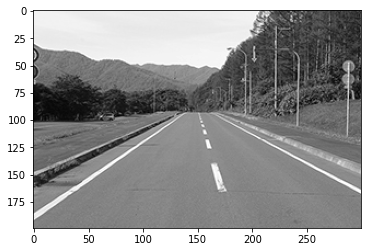

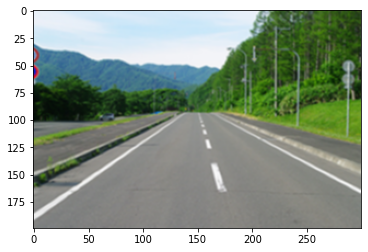

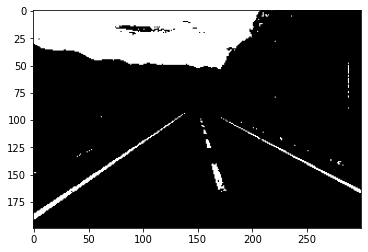

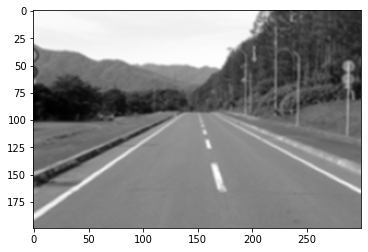

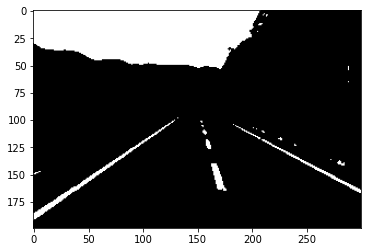

In [3]:
clr_blur=(3,3)
gray_blur=(5,5)
lower_clr_range=(180,180,180)

gray_img = grayscale(img)
plt_imshow(gray_img)

blur_img = cv2.GaussianBlur(img, clr_blur,0)
plt_imshow(blur_img, is_bgr=True)

bin_img = cv2.inRange(img, (200,200,200), (255,255,255)) # 色を選択する
plt_imshow(bin_img)

gray_blur_img = cv2.GaussianBlur(gray_img, gray_blur,0)
plt_imshow(gray_blur_img)

bin_blur_img = cv2.inRange(blur_img, lower_clr_range, (255,255,255)) # 色を選択する
plt_imshow(bin_blur_img)

In [4]:
param = {'canny':
    {'low_threshold': 150,
    'high_threshold': 250},
    'hough':
    {'rho': 1, # 2
    'threshold': 20, # 20
    'min_line_len': 50,
    'max_line_gap': 20},
  'region_rate':
    {'left_bottom_rate':[0,0.8],
    'left_top_rate':[0.3, 0.3],
    'right_top_rate':[0.7, 0.3],
    'right_bottom_rate':[1, 0.8]}
    }


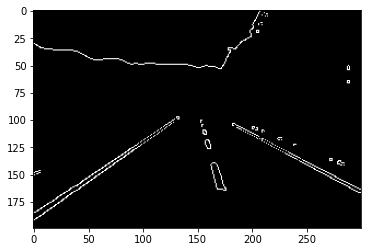

In [5]:
# detect_line = pipeline_calc_white_lines(bin_blur_img, param,DEBUG=True)
edges = canny(bin_blur_img, low_threshold=150, high_threshold=250)
plt_imshow(edges)

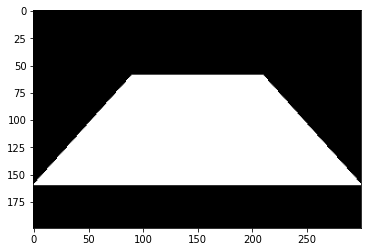

In [6]:

# 画像shapeに対する取得領域(4点)を縦横の比率で指定
imshape = np.array(edges.T.shape).T # 画像のshape(W, H)
left_bottom = imshape * np.array([0,0.8]) # 左下の座標
left_top = imshape * np.array([0.3, 0.3]) # 左上の座標
right_top = imshape * np.array([0.7, 0.3]) # 右上の座標
right_bottom = imshape * np.array([1, 0.8]) # 右下の座標
region_coord = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32) # 先行車領域の座標4点(左下から時計回り)

## define a four sided polygon to mask
mask = np.zeros_like(edges)
# region_coord = calc_region(np.array(gray_img.T.shape), **param['region_rate'])
# vertices = np.array([region_coord], dtype=np.int32)
cv2.fillPoly(mask, region_coord, color=255)

plt_imshow(mask)

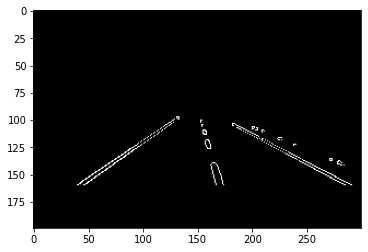

In [7]:
# mask edges by region
masked_edges = cv2.bitwise_and(edges, mask)
plt_imshow(masked_edges)

In [8]:
"""
rho: distance resolution in pixels of the Hough grid
theta: angular resolution in radians of the Hough grid
threshold: minimum number of votes (intersections in Hough grid cell)
min_line_len: minimum number of pixels making up a line
max_line_gap: maximum gap in pixels between connectable line segments
"""

# detect_line = hough_lines(masked_edges, theta=np.pi/180, **param['hough']) # Lineのみの画像
detect_line = hough_lines(masked_edges, threshold=20, min_line_len=50, max_line_gap=20, rho=1, theta=np.pi/180) # Lineのみの画像



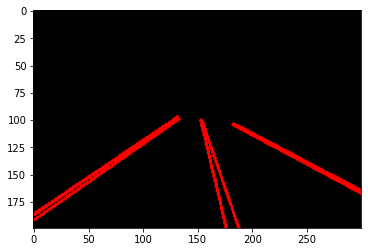

In [9]:
plt_imshow(detect_line)

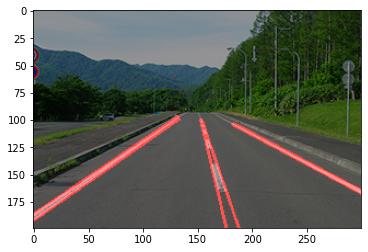

In [10]:
overlay_img = weighted_img(img, cv2.cvtColor(detect_line,cv2.COLOR_RGB2BGR), a=0.6)
plt_imshow(overlay_img, is_bgr=True)

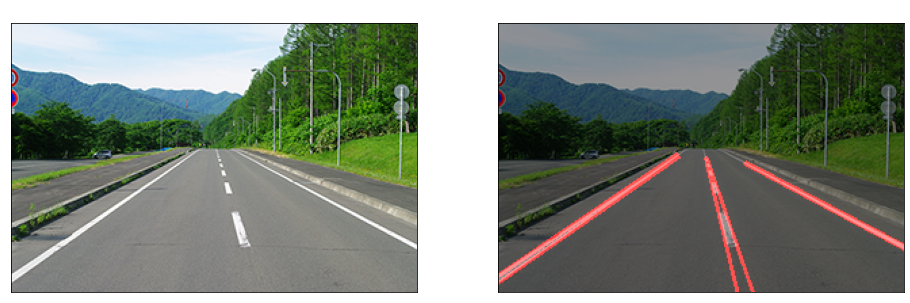

In [11]:
def vis(images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title(),color='white')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

vis({'original': img, 'goal':overlay_img})
# vis({'original': img, 'blur':blur_img})
# vis({'original': img, 'bin_blur':bin_blur_img})
# vis({'original': img, 'edges':edges})
# vis({'edges': edges, 'mask':mask, 'masked_edges':masked_edges})
# vis({'detect_line': cv2.cvtColor(detect_line,cv2.COLOR_RGB2BGR), 'overlay_img':overlay_img})
